In [1]:
#import packages 

from glob import glob
import pandas as pd
import os
import shutil
import math
import numpy as np

folder_path="./dataset/subset/"
folders = glob(folder_path+'complete/*')

train_split=0.7
no_of_images=0

In [2]:
#split data to training and testing
'''
def createFolder(path):
	if os.path.exists(path):
		shutil.rmtree(path)
	os.makedirs(path)

createFolder(folder_path+"train")
createFolder(folder_path+"test")

for folder in folders:
    images = glob(folder+'/*.jpg')
    name = folder.split('/')[-1]
    createFolder(folder_path+"train/"+name)
    createFolder(folder_path+"test/"+name)
    train_images=math.floor(train_split*len(images))
    for i,image in enumerate(images):
        if(i<=train_images-1):
            shutil.copy(image,folder_path+"train/"+name)
        else:
            shutil.copy(image,folder_path+"test/"+name)
        no_of_images+=1
    print(name)
'''

'\ndef createFolder(path):\n\tif os.path.exists(path):\n\t\tshutil.rmtree(path)\n\tos.makedirs(path)\n\ncreateFolder(folder_path+"train")\ncreateFolder(folder_path+"test")\n\nfor folder in folders:\n    images = glob(folder+\'/*.jpg\')\n    name = folder.split(\'/\')[-1]\n    createFolder(folder_path+"train/"+name)\n    createFolder(folder_path+"test/"+name)\n    train_images=math.floor(train_split*len(images))\n    for i,image in enumerate(images):\n        if(i<=train_images-1):\n            shutil.copy(image,folder_path+"train/"+name)\n        else:\n            shutil.copy(image,folder_path+"test/"+name)\n        no_of_images+=1\n    print(name)\n'

In [3]:
#generate train and test data

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   rotation_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(folder_path+"train/",
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(folder_path+"test/",
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Using TensorFlow backend.


Found 8751 images belonging to 5 classes.
Found 3753 images belonging to 5 classes.


In [4]:
# Importing the Keras libraries and packages
from keras.models import Sequential,save_model,load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers.core import Dense, Dropout
from keras.applications import VGG16,Xception,ResNet50,nasnet
from keras.callbacks import ModelCheckpoint,EarlyStopping, TensorBoard
from keras.optimizers import SGD,rmsprop,Adam

# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 5, activation = 'softmax'))
# Compiling the CNN
# opt = rmsprop(lr=0.0001, decay=1e-6)
# opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(optimizer = 'adam',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])
classifier.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [ ]:

# Part 2 - Fitting the CNN to the images

tensorboard=TensorBoard(log_dir='./logs/', histogram_freq=0, 
                         batch_size=32, write_graph=True, 
                         write_grads=True, write_images=True)

checkpointer = ModelCheckpoint(filepath='./output_models/Model{epoch:02d}_{val_acc:.2f}.h5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                               patience=5, verbose=1, mode='auto')

classifier.fit_generator(training_set,
                         steps_per_epoch = 600,
                         epochs = 1000,
                         validation_data = test_set,
                         validation_steps = 30,
                         callbacks =[tensorboard,early_stopping,checkpointer])

In [5]:
classifier.save('./output_models/cnn_82_5.h5')

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [45]:
classifier = load_model('./output_models/cnn_867.h5')

In [46]:
final_test_set = test_datagen.flow_from_directory(folder_path+"test/",
                                            shuffle=False,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

y_pred = classifier.predict_generator(final_test_set)
df=pd.DataFrame(y_pred,columns=['c0','c1','c2','c3','c4'])
y_pred = np.argmax(y_pred,axis = 1) 
y_actual = final_test_set.classes
df["filenames"]=final_test_set.filenames
df["actual"]=y_actual
df["predicted"]=y_pred
df.to_csv("./output_models/predictions_custom_cnn_867.csv")
classnames=[]
for classname in final_test_set.class_indices:
    classnames.append(classname)


Found 3753 images belonging to 5 classes.


In [48]:
confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[667  40  27  41  20]
 [ 25 498  25  22   8]
 [ 29  36 390  12 107]
 [ 17  10   4 893   7]
 [ 15  25  35  11 789]]
                    precision    recall  f1-score   support

           BabyHat       0.89      0.84      0.86       795
         BabyPants       0.82      0.86      0.84       578
         BabyShirt       0.81      0.68      0.74       574
  womencasualshoes       0.91      0.96      0.94       931
womenlongsleevetop       0.85      0.90      0.87       875

       avg / total       0.86      0.86      0.86      3753



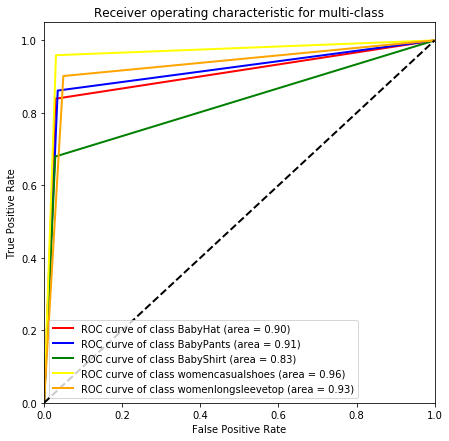

In [73]:
-